#### NX-414: Brain-like computation and intelligence
Notebook prepared by Alessandro Marin Vargas

# Week 8 - Mini projects (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. Here, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

# Challenge: Develop the most accurate model for predicting IT neural activity.

Throughout the mini-projects, you have acquired knowledge on predicting neural activity through both task-driven and data-driven approaches. You are now free to explore both approaches to create the most effective model for predicting neural activity. Here are some suggestions to help guide your exploration:
- Optimize your current models by adjusting hyperparameters and implementing different regularizations.
- Utilize different pretrained models.
- Employ a pretrained neural network and finetune it for predicting the neural activity.
- Train a neural network for object recognition while simultaneously predicting neural activity.
- ...

Please note that all models will be tested using the same type of linear regression.

### EVALUATION

You have until midnight of 07/05/25 to submit your mini-projects. Please upload a .zip file on Moodle containing your code and, specifically, the following:

- A one-page report (Report.pdf) detailing your investigation, including figures and model comparisons.
- A script (test.py) or notebook (test.ipynb) in which you show an example of your best model's usage. Please include instructions on loading the model and making neural predictions on the validation set. If necessary, include the checkpoint of your model in the .zip file.

Best of luck!

=========================================================================================

From BrainScore "resnet50_barlow" is ranked 1st for alignment on IT data from MajajHong2015. "layer4.0" is best aligned on IT.

https://www.brain-score.org/model/vision/1310

https://github.com/facebookresearch/barlowtwins


In [2]:
%reload_ext autoreload
%autoreload 2

In [1]:
from utils import *
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from torchvision.models.feature_extraction import create_feature_extractor
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.model_selection import StratifiedKFold
import torch
from tqdm import tqdm
from torchinfo import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Computation on {device}.")

path_to_data = ''
stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)
n_stimulus = stimulus_train.shape[0]

Computation on cuda.


In [ ]:
model = torch.hub.load('facebookresearch/barlowtwins:main', 'resnet50')
model = model.to(device)
model.eval()

Using cache found in /home/gotti/.cache/torch/hub/facebookresearch_barlowtwins_main
/home/gotti/.virtualenvs/brain/lib64/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gotti/.virtualenvs/brain/lib64/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Computation on cuda.


In [4]:
summary(model)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─Bottleneck: 2-1                   --
│    │    └─Conv2d: 3-1                  4,096
│    │    └─BatchNorm2d: 3-2             128
│    │    └─Conv2d: 3-3                  36,864
│    │    └─BatchNorm2d: 3-4             128
│    │    └─Conv2d: 3-5                  16,384
│    │    └─BatchNorm2d: 3-6             512
│    │    └─ReLU: 3-7                    --
│    │    └─Sequential: 3-8              16,896
│    └─Bottleneck: 2-2                   --
│    │    └─Conv2d: 3-9                  16,384
│    │    └─BatchNorm2d: 3-10            128
│    │    └─Conv2d: 3-11                 36,864
│    │    └─BatchNorm2d: 3-12            128
│    │    └─Conv2d: 3-13               

In [3]:
return_node = 'layer4.0'
dir = 'tmp'

In [ ]:
imgs_tr = torch.from_numpy(stimulus_train).to(device)
imgs_val = torch.from_numpy(stimulus_val).to(device)

with torch.no_grad():
    print(f"Extracting {return_node} activations...")
    
    # Forward training set
    extractor = create_feature_extractor(model, return_nodes={return_node:return_node})
    activation_tr = extractor(imgs_tr)[return_node]
    fname = f"{dir}/{return_node}_train.pt"
    torch.save(activation_tr.detach().cpu(), fname)
    print(f"Saved training activations to {fname}")

    # Forward validation set
    activation_val = extractor(imgs_val)[return_node]
    fname = f"{dir}/{return_node}_val.pt"
    torch.save(activation_val.detach().cpu(), fname)
    print(f"Saved validation activations to {fname}")

    torch.cuda.empty_cache()


Extracting layer4.0 activations...
Saved training activations to tmp/layer4.0_train.pt
Saved validation activations to tmp/layer4.0_val.pt


In [4]:
print(f"Loading activations from {dir}...")
activation_tr = torch.load(f"{dir}/{return_node}_train.pt")
activation_val = torch.load(f"{dir}/{return_node}_val.pt")
print(f"Training activations shape: {activation_tr.shape}")
print(f"Validation activations shape: {activation_val.shape}")

flatten_activations_tr = torch.reshape(activation_tr, (activation_tr.shape[0], -1))
flatten_activations_val = torch.reshape(activation_val, (activation_val.shape[0], -1))

Loading activations from tmp...
Training activations shape: torch.Size([2592, 2048, 7, 7])
Validation activations shape: torch.Size([288, 2048, 7, 7])


In [5]:
# Run PCA
pca = PCA(n_components=0.9)
pca_activations_tr = torch.tensor(pca.fit_transform(flatten_activations_tr.cpu().numpy()))
pca_activations_val = torch.tensor(pca.transform(flatten_activations_val.cpu().numpy()))

In [6]:
# Put data on correct device
pca_activations_tr = pca_activations_tr.to(device)
pca_activations_val = pca_activations_val.to(device)
spikes_train = torch.tensor(spikes_train, dtype=torch.float32, device=device)
spikes_val = torch.tensor(spikes_val, dtype=torch.float32, device=device)

In [7]:
from dataset import ActivationsDataset
from torch.utils.data import DataLoader

train_dataset = ActivationsDataset(pca_activations_tr, spikes_train, device)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

val_inputs = pca_activations_val
val_targets = spikes_val

# Display 1st batch shape
for activation_batch, spikes_batch in train_loader:
    input_size = activation_batch.shape[1]
    print(f"Activations batch shape: {activation_batch.shape}")
    print(f"Spikes batch shape: {spikes_batch.shape}")
    break

print(f"Activations validation shape: {val_inputs.shape}")
print(f"Spikes validation shape: {val_targets.shape}")

Activations batch shape: torch.Size([8, 1512])
Spikes batch shape: torch.Size([8, 168])
Activations validation shape: torch.Size([288, 1512])
Spikes validation shape: torch.Size([288, 168])


In [15]:
import torch.nn as nn
import torch.nn.functional as F

class ActivationsFFN(nn.Module):
    def __init__(self, input_size=input_size, hidden_1_size=2**10, hidden_2_size=2**9, output_size=168, dropout=0):
        super(ActivationsFFN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_1_size)
        self.fc2 = nn.Linear(hidden_1_size, hidden_2_size)
        self.fc3 = nn.Linear(hidden_2_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [8]:
activations_ffn = ActivationsFFN().to(device)
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(activations_ffn.parameters(), lr=0.001)

In [9]:
summary(activations_ffn)

Layer (type:depth-idx)                   Param #
ActivationsFFN                           --
├─Linear: 1-1                            1,549,312
├─Linear: 1-2                            524,800
├─Linear: 1-3                            86,184
Total params: 2,160,296
Trainable params: 2,160,296
Non-trainable params: 0

In [24]:
train_model(activations_ffn, loss_fn, opt, train_loader, val_inputs, val_targets, explained_variance_score, epochs=100)

Ep 1/100, it 324/324: loss train: 0.10, metric validation: 0.29
Ep 2/100, it 324/324: loss train: 0.09, metric validation: 0.32
Ep 3/100, it 324/324: loss train: 0.08, metric validation: 0.34
Ep 4/100, it 324/324: loss train: 0.07, metric validation: 0.34
Ep 5/100, it 324/324: loss train: 0.08, metric validation: 0.36
Ep 6/100, it 324/324: loss train: 0.08, metric validation: 0.35
Ep 7/100, it 324/324: loss train: 0.07, metric validation: 0.36
Ep 8/100, it 324/324: loss train: 0.06, metric validation: 0.35
Ep 9/100, it 324/324: loss train: 0.07, metric validation: 0.35
Ep 10/100, it 324/324: loss train: 0.08, metric validation: 0.35
Ep 11/100, it 324/324: loss train: 0.06, metric validation: 0.36
Ep 12/100, it 324/324: loss train: 0.09, metric validation: 0.33
Ep 13/100, it 324/324: loss train: 0.06, metric validation: 0.35
Ep 14/100, it 324/324: loss train: 0.08, metric validation: 0.35
Ep 15/100, it 324/324: loss train: 0.07, metric validation: 0.35
Ep 16/100, it 324/324: loss train:

-- ActivationsFFN --
Mean EV: 0.35202184
Mean Pearson correlation: 0.58248705


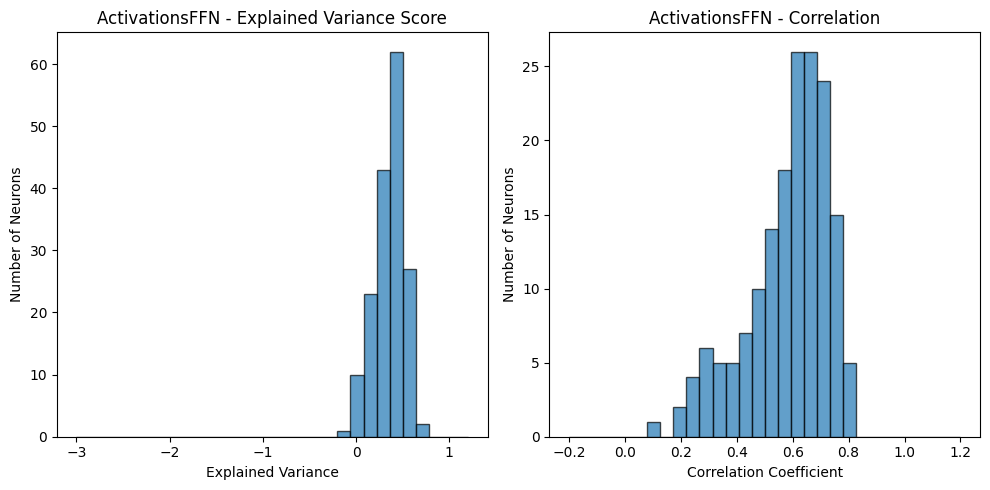

In [25]:
activations_ffn.eval()
predictions_ffn = activations_ffn(val_inputs).detach().cpu().numpy()
predictions = {
    "ActivationsFFN": predictions_ffn
}
evaluation_metrics(predictions, spikes_val)

In [16]:
# Run a grid search to find the best hyperparameters
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV

net = NeuralNetRegressor(
    ActivationsFFN,
    max_epochs=20,
    lr=0.001,
    verbose=0,
    train_split=False,
    optimizer=torch.optim.Adam,
    device=device
)

params = {
    'optimizer__weight_decay': [0.0, 0.001, 0.01, 0.1],
    'module__dropout': [0, 0.2, 0.35, 0.5],
    'lr': [0.001, 0.01, 0.1],
}

gs = GridSearchCV(net, params, refit=True, cv=3, scoring='explained_variance', verbose=2)

gs.fit(pca_activations_tr.cpu().numpy(), spikes_train.cpu().numpy())

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[CV] END lr=0.001, module__dropout=0, optimizer__weight_decay=0.0; total time=   0.7s
[CV] END lr=0.001, module__dropout=0, optimizer__weight_decay=0.0; total time=   0.7s
[CV] END lr=0.001, module__dropout=0, optimizer__weight_decay=0.0; total time=   0.7s
[CV] END lr=0.001, module__dropout=0, optimizer__weight_decay=0.001; total time=   0.7s
[CV] END lr=0.001, module__dropout=0, optimizer__weight_decay=0.001; total time=   0.7s
[CV] END lr=0.001, module__dropout=0, optimizer__weight_decay=0.001; total time=   0.7s
[CV] END lr=0.001, module__dropout=0, optimizer__weight_decay=0.01; total time=   0.7s
[CV] END lr=0.001, module__dropout=0, optimizer__weight_decay=0.01; total time=   0.7s
[CV] END lr=0.001, module__dropout=0, optimizer__weight_decay=0.01; total time=   0.7s
[CV] END lr=0.001, module__dropout=0, optimizer__weight_decay=0.1; total time=   0.7s
[CV] END lr=0.001, module__dropout=0, optimizer__weight_decay=0.1; total time=   0.7s
[CV] END lr=0.001, module__dropout=0, optimiz

GridSearchCV(cv=3,
             estimator=NeuralNetRegressor(_params_to_validate=set(), batch_size=128, callbacks=None, compile=False, dataset=<class 'skorch.dataset.Dataset'>, device=device(type='cuda'), iterator_train=<class 'torch.utils.data.dataloader.DataLoader'>, iterator_valid=<class 'torch.utils.data.dataloader.DataLoader'>, lr=0.001, max_epochs=20, module=<class '__main__.ActivationsFFN'>, optimizer=<class 'torch.optim.adam.Adam'>, predict_nonlinearity='auto', torch_load_kwargs=None, train_split=False, use_caching='auto', verbose=0, warm_start=False),
             param_grid={'lr': [0.001, 0.01, 0.1],
                         'module__dropout': [0, 0.2, 0.35, 0.5],
                         'optimizer__weight_decay': [0.0, 0.001, 0.01, 0.1]},
             scoring='explained_variance', verbose=2)

In [17]:
print(gs.best_score_, gs.best_params_)

0.3805333574612935 {'lr': 0.001, 'module__dropout': 0, 'optimizer__weight_decay': 0.001}


-- ActivationsFFNGridSearch --
Mean EV: 0.435015
Mean Pearson correlation: 0.6511894


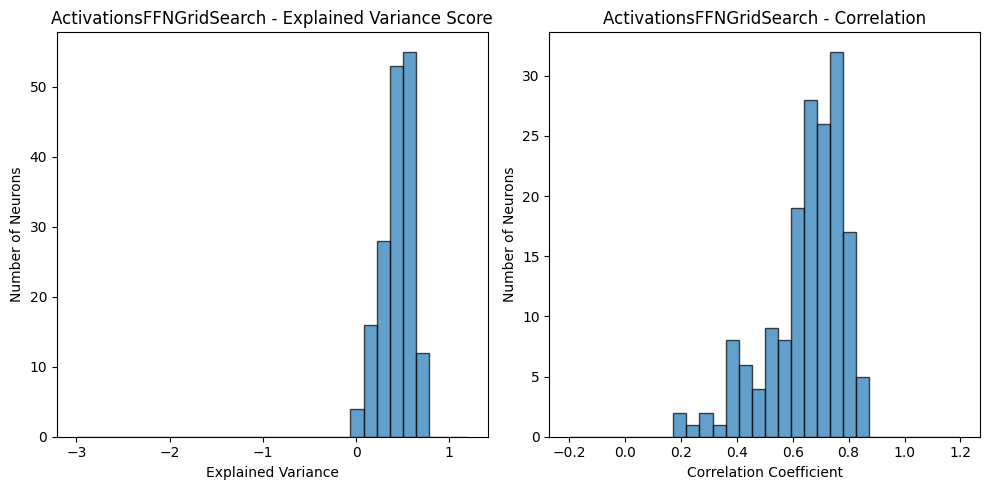

In [18]:
predictions_ffn = gs.best_estimator_.predict(pca_activations_val.cpu().numpy())
predictions = {
    "ActivationsFFNGridSearch": predictions_ffn
}
evaluation_metrics(predictions, spikes_val.cpu().numpy())